# MaxEnt

In [1]:
import time
import math
import numpy as np
from MDPGridWorld import *
from maxent_irl import *
from plotting import *

%load_ext autoreload
%autoreload 2

In [2]:
def terminal_state_potential_fn(s_idx, terminal_state_idx):
    
    if s_idx == terminal_state_idx:
        return 0
    else:
        return -1e20

In [3]:
def run_max_ent_gridworld_experiment(grid,
                                     n_traj, 
                                     max_traj_len, 
                                     n_epochs,
                                     learning_rate,
                                     action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-6,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     avoid_obstacles=True,
                                     gamma=0.99,
                                     silent=False):
    
    gw = MDPGridWorld(grid, living_reward, gamma, action_noise_dist, obstacle_reward, silent=True)
    phi=lambda x: terminal_state_potential_fn(x, gw.absorbing_state_idx)
    trajectories = np.asarray(gw.sample_trajectories(n_traj, init_state_idx=init_state_idx, 
                                                     max_length=max_traj_len, avoid_obtacles=avoid_obstacles), dtype=np.int)
    start = time.time()
    if linear_features:
        feature_matrix = gw.get_state_grid_features_matrix()
    else:
        feature_matrix = gw.get_state_2d_features_matrix()
        
    R = max_ent_irl(trajectories, feature_matrix, 
                    gw.gamma, gw.nA, gw.T, 
                    n_epochs, learning_rate, 
                    phi, vi_eps=vi_eps, silent=silent)
    print("Epochs:{} Total Time: {} sec".format(n_epochs, time.time()-start))
    return R, gw, trajectories, feature_matrix

In [4]:
def plot_results(gw, grid, R, n_epochs, learning_rate):

    plt.figure(figsize=(14,8))
    print("Expert Policy")
    gw.disp_custom_grid(gw.vi_results.policy, lambda x: "{:}".format(gw.actions_name[x]))
    vi_recovered = run_value_iteration(gw.T, R, gw.gamma)
    print("Recovered Policy")
    gw.disp_custom_grid(vi_recovered.policy, lambda x: "{:}".format(gw.actions_name[x]))
    compare_grid_data(gw.vi_results.policy, vi_recovered.policy, gw.height, gw.width, 
                      suffix="policy:", 
                      grid=grid, plots=[(2,2,1), (2,2,2)])
    
    print("Groundtruth R")
    gw.disp_custom_grid(gw.R, formatting=lambda x: "{:.3f}".format(x))
    print("Recovered R")
    gw.disp_custom_grid(R, formatting=lambda x: "{:.3f}".format(x))
    
    compare_grid_data(gw.R, R, gw.height, gw.width, suffix="reward ", 
                      title2="MaxEnt inferred. \nIter={}, lr={}".format(n_epochs, learning_rate), 
                      grid=grid, plots=[(2,2,3), (2,2,4)])

## Determinitic Dynamics & Linear Rewards (True R = w.dot(fs))

In [5]:
action_noise_dist = [0., 1., 0.]

### Simple Grid

 Epoch 0, sum|grad|: 18.648374390198466
 Epoch 1, sum|grad|: 18.26264595078962
 Epoch 2, sum|grad|: 6.950894780041902
 Epoch 3, sum|grad|: 4.22991963505522
 Epoch 4, sum|grad|: 2.7885185940549158
 Epoch 5, sum|grad|: 2.065571132858148
 Epoch 6, sum|grad|: 1.7056516951705674
 Epoch 7, sum|grad|: 1.451517720302596
 Epoch 8, sum|grad|: 1.2528143268486645
 Epoch 9, sum|grad|: 1.0936114268697006
 Epoch 10, sum|grad|: 0.9657602916327317
 Epoch 11, sum|grad|: 0.8634760053371049
 Epoch 12, sum|grad|: 0.7817394780302642
 Epoch 13, sum|grad|: 0.7161345019226059
 Epoch 14, sum|grad|: 0.6629751213249809
 Epoch 15, sum|grad|: 0.6281748191760267
 Epoch 16, sum|grad|: 0.6019674604955447
 Epoch 17, sum|grad|: 0.5833226015638718
 Epoch 18, sum|grad|: 0.5659405206414356
 Epoch 19, sum|grad|: 0.5497333083031487
Epochs:20 Total Time: 19.769999265670776 sec
Expert Policy
East	East	East	East	South	
East	East	East	East	South	
East	East	East	East	South	
East	East	East	East	South	
East	East	East	East	North	
Ab

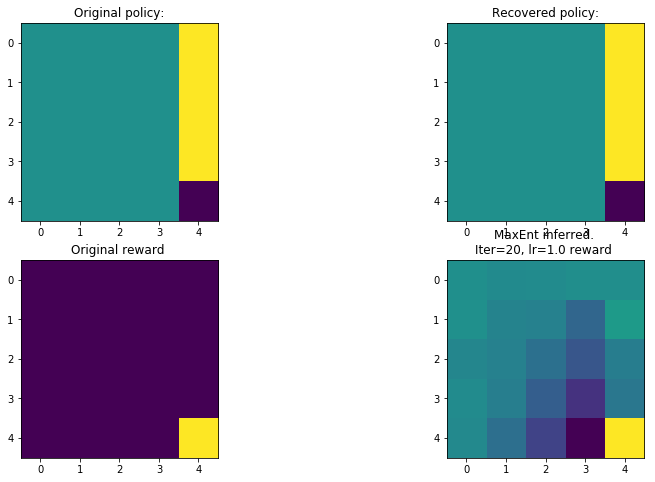

In [6]:
np.random.seed(0)
grid = [[' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',+1]]
n_epochs, lr = 20, 1.
n_traj, max_traj_len = 100, 20
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-6,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     avoid_obstacles=True,
                                     gamma=0.99,
                                     silent=False)
plot_results(gw, grid, R, n_epochs, lr)

### Grid with obstacles

 Epoch 0, sum|grad|: 17.530824352728885
 Epoch 1, sum|grad|: 10.359309358969773
 Epoch 2, sum|grad|: 1.9797926690931207
 Epoch 3, sum|grad|: 1.4481911437864932
 Epoch 4, sum|grad|: 1.224148382390526
 Epoch 5, sum|grad|: 1.0814855097282865
 Epoch 6, sum|grad|: 0.9802769958201822
 Epoch 7, sum|grad|: 0.904884278036114
 Epoch 8, sum|grad|: 0.8470555382734138
 Epoch 9, sum|grad|: 0.79684054038251
 Epoch 10, sum|grad|: 0.7527328327413846
 Epoch 11, sum|grad|: 0.7136171538459538
 Epoch 12, sum|grad|: 0.6786555053449754
 Epoch 13, sum|grad|: 0.6476006997113327
 Epoch 14, sum|grad|: 0.6201936249276274
 Epoch 15, sum|grad|: 0.5951841977613284
 Epoch 16, sum|grad|: 0.5722806609207891
 Epoch 17, sum|grad|: 0.5512361272909702
 Epoch 18, sum|grad|: 0.531839794993685
 Epoch 19, sum|grad|: 0.5139103997017455
Epochs:20 Total Time: 19.8835289478302 sec
Expert Policy
East	East	East	East	South	
South	North	East	East	South	
East	South	North	East	South	
East	East	South	North	South	
East	East	East	East	Nort

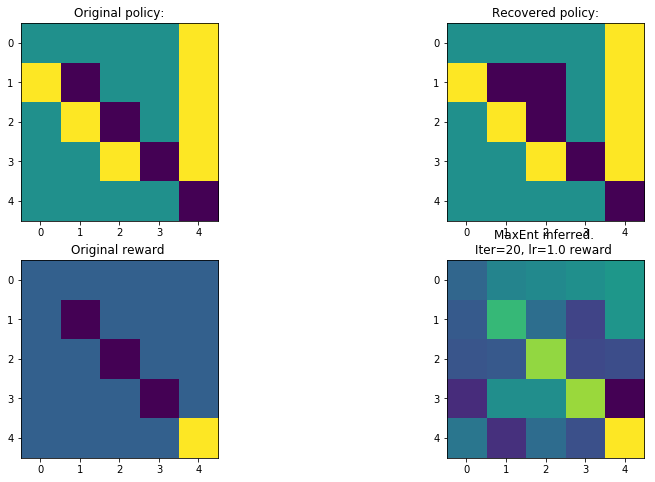

In [7]:
np.random.seed(0)
grid = [[' ',' ',' ',' ',' '],
                [' ','#',' ',' ',' '],
                [' ',' ','#',' ',' '],
                [' ',' ',' ','#',' '],
                [' ',' ',' ',' ',+1]]
n_epochs, lr = 20, 1.
n_traj, max_traj_len = 100, 20
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-6,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     avoid_obstacles=True,
                                     gamma=0.99,
                                     silent=False)
plot_results(gw, grid, R, n_epochs, lr)

### R&N Chap. 17 Grid World

 Epoch 0, sum|grad|: 12.339620050453485
 Epoch 1, sum|grad|: 2.5727959128235582
 Epoch 2, sum|grad|: 1.2105940334848282
 Epoch 3, sum|grad|: 0.9161723981080909
 Epoch 4, sum|grad|: 0.824060899449448
 Epoch 5, sum|grad|: 0.7429272762373428
 Epoch 6, sum|grad|: 0.6739495344973397
 Epoch 7, sum|grad|: 0.6156367644771696
 Epoch 8, sum|grad|: 0.5659992920960992
 Epoch 9, sum|grad|: 0.5233609917248397
 Epoch 10, sum|grad|: 0.48643735216216033
 Epoch 11, sum|grad|: 0.4542496860018784
 Epoch 12, sum|grad|: 0.4260354445862816
 Epoch 13, sum|grad|: 0.40118389630717327
 Epoch 14, sum|grad|: 0.3791946030601322
 Epoch 15, sum|grad|: 0.35965114615286026
 Epoch 16, sum|grad|: 0.34220394739924737
 Epoch 17, sum|grad|: 0.32655825583222403
 Epoch 18, sum|grad|: 0.31308269071270234
 Epoch 19, sum|grad|: 0.3036507152828814
Epochs:20 Total Time: 9.76924204826355 sec
Expert Policy
East	East	East	North	
North	North	North	North	
North	East	North	West	
Absorbing state: North
Recovered Policy
East	East	East	Nor

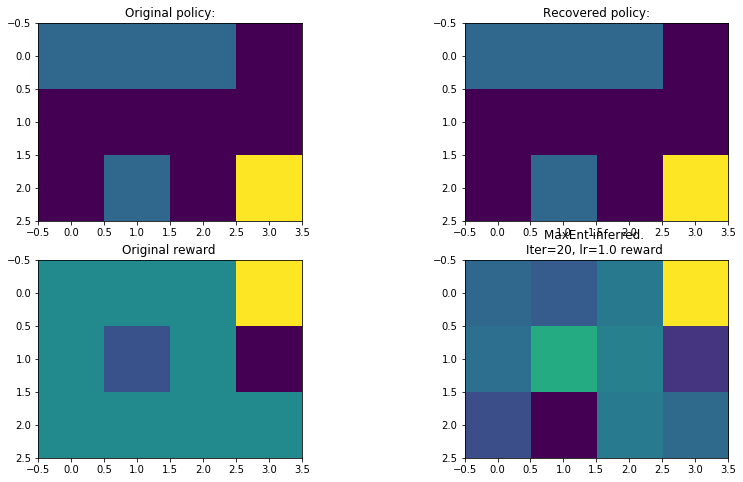

In [8]:
np.random.seed(0)
grid = [[' ',' ',' ',+1],
            [' ','#',' ',-1],
            ['@',' ',' ',' ']]
n_epochs, lr = 20, 1.
n_traj, max_traj_len = 400, 15
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-6,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     avoid_obstacles=True,
                                     gamma=0.99,
                                     silent=False)
plot_results(gw, grid, R, n_epochs, lr)

## Stochastic Dynamics & Linear Rewards (True R = w.dot(fs))

In [9]:
action_noise_dist = [0.1, 0.8, 0.1]

### Simple Grid

 Epoch 0, sum|grad|: 12.206361609747576
 Epoch 1, sum|grad|: 2.5225591577815636
 Epoch 2, sum|grad|: 1.8168448266298176
 Epoch 3, sum|grad|: 1.580150235668847
 Epoch 4, sum|grad|: 1.413811523052707
 Epoch 5, sum|grad|: 1.2855222644338875
 Epoch 6, sum|grad|: 1.1867767905392046
 Epoch 7, sum|grad|: 1.1048958917024694
 Epoch 8, sum|grad|: 1.0354279821841654
 Epoch 9, sum|grad|: 0.9755771669391774
 Epoch 10, sum|grad|: 0.9233546499678167
 Epoch 11, sum|grad|: 0.8773022954971492
 Epoch 12, sum|grad|: 0.8371984232089242
 Epoch 13, sum|grad|: 0.8033682137500178
 Epoch 14, sum|grad|: 0.7725266290377848
 Epoch 15, sum|grad|: 0.7442697386732648
 Epoch 16, sum|grad|: 0.7182667033095151
 Epoch 17, sum|grad|: 0.6942433573430304
 Epoch 18, sum|grad|: 0.6719701257660002
 Epoch 19, sum|grad|: 0.6512529851937643
 Epoch 20, sum|grad|: 0.6319265987792837
 Epoch 21, sum|grad|: 0.613849028479234
 Epoch 22, sum|grad|: 0.5968976092680387
 Epoch 23, sum|grad|: 0.580965691572938
 Epoch 24, sum|grad|: 0.565960

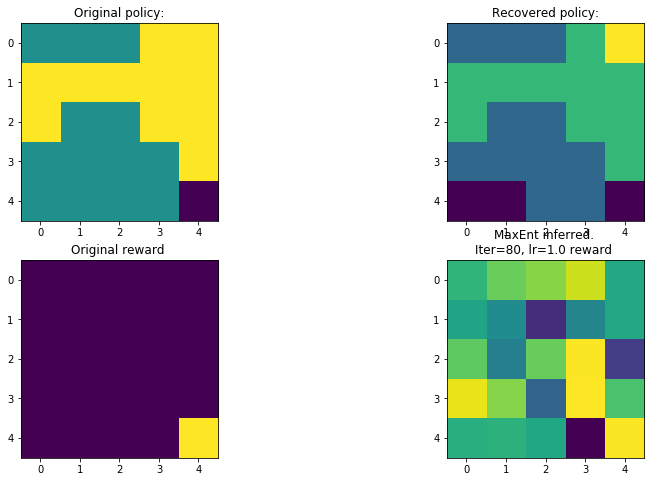

In [20]:
np.random.seed(0)
grid = [[' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',+1]]
n_epochs, lr = 80, 1.
n_traj, max_traj_len = 20000, 40
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-3,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     avoid_obstacles=True,
                                     gamma=0.99,
                                     silent=False)
plot_results(gw, grid, R, n_epochs, lr)

### Grid with obstacles

 Epoch 0, sum|grad|: 36.45320546603284
 Epoch 1, sum|grad|: 5.220857199109523
 Epoch 2, sum|grad|: 2.332758579644362
 Epoch 3, sum|grad|: 1.8920557145197618
 Epoch 4, sum|grad|: 1.6048166921960425
 Epoch 5, sum|grad|: 1.3964869536801692
 Epoch 6, sum|grad|: 1.2378413487093183
 Epoch 7, sum|grad|: 1.1132619314207377
 Epoch 8, sum|grad|: 1.0131415253594824
 Epoch 9, sum|grad|: 0.9311345607372351
 Epoch 10, sum|grad|: 0.8628699567356362
 Epoch 11, sum|grad|: 0.8052466205604938
 Epoch 12, sum|grad|: 0.7560118221682515
 Epoch 13, sum|grad|: 0.7134953172235827
 Epoch 14, sum|grad|: 0.6767364554971241
 Epoch 15, sum|grad|: 0.6491582386938101
 Epoch 16, sum|grad|: 0.6244137445514176
 Epoch 17, sum|grad|: 0.6020667511766274
 Epoch 18, sum|grad|: 0.5817687563753299
 Epoch 19, sum|grad|: 0.5632378521709849
Epochs:20 Total Time: 20.89884305000305 sec
Expert Policy
East	East	East	East	South	
South	North	East	East	South	
South	South	North	East	South	
South	South	South	North	South	
East	East	East	Eas

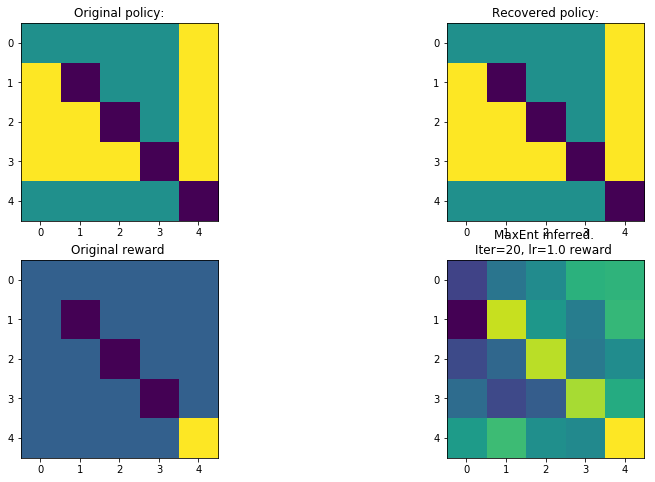

In [21]:
np.random.seed(0)
grid = [[' ',' ',' ',' ',' '],
                [' ','#',' ',' ',' '],
                [' ',' ','#',' ',' '],
                [' ',' ',' ','#',' '],
                [' ',' ',' ',' ',+1]]
n_epochs, lr = 20, 1.
n_traj, max_traj_len = 400, 40
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-6,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     avoid_obstacles=True,
                                     gamma=0.99,
                                     silent=False)
plot_results(gw, grid, R, n_epochs, lr)

### R&N Chap. 17 Grid World

 Epoch 0, sum|grad|: 22.551566710592148
 Epoch 1, sum|grad|: 3.498570446029298
 Epoch 2, sum|grad|: 2.125418931313898
 Epoch 3, sum|grad|: 1.9337095853830046
 Epoch 4, sum|grad|: 1.8241472522497422
 Epoch 5, sum|grad|: 1.7398972966770108
 Epoch 6, sum|grad|: 1.6569729363432
 Epoch 7, sum|grad|: 1.55490530051165
 Epoch 8, sum|grad|: 1.4227130670033399
 Epoch 9, sum|grad|: 1.277391554716635
 Epoch 10, sum|grad|: 1.1494019808255653
 Epoch 11, sum|grad|: 1.064734055408376
 Epoch 12, sum|grad|: 1.0024761934422253
 Epoch 13, sum|grad|: 0.9502060345727523
 Epoch 14, sum|grad|: 0.9032796538567589
 Epoch 15, sum|grad|: 0.8581043209909369
 Epoch 16, sum|grad|: 0.8117197104950877
 Epoch 17, sum|grad|: 0.7615534930149108
 Epoch 18, sum|grad|: 0.7055888968378045
 Epoch 19, sum|grad|: 0.6430632595844215
Epochs:20 Total Time: 10.092535018920898 sec
Expert Policy
East	East	East	North	
North	North	North	North	
North	West	North	West	
Absorbing state: North
Recovered Policy
East	East	East	North	
North	No

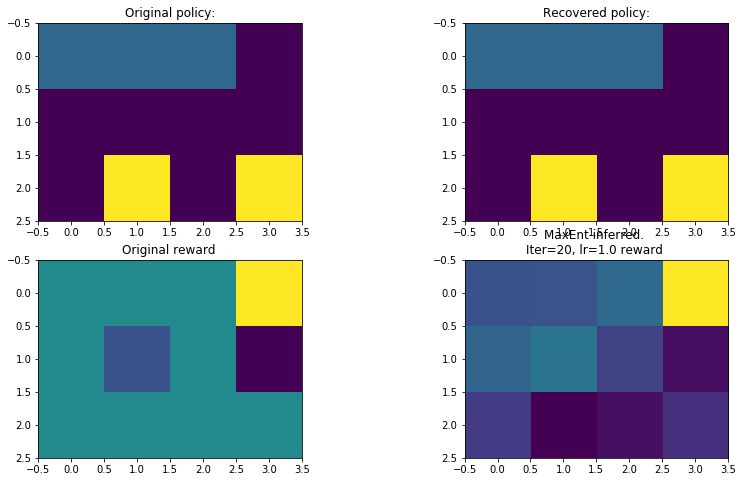

In [24]:
np.random.seed(0)
grid = [[' ',' ',' ',+1],
            [' ','#',' ',-1],
            ['@',' ',' ',' ']]
n_epochs, lr = 20, 1.
n_traj, max_traj_len = 1200, 30
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-6,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     avoid_obstacles=True,
                                     gamma=0.99,
                                     silent=False)
plot_results(gw, grid, R, n_epochs, lr)